# Lasso linear regression (i.e. l1-regularized linear regression)

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

The Lasso functional we seek to minimize is the following:

\begin{align}
L(w) = \operatorname{RSS}(w) + \alpha||w||_1^2 \ ,
\end{align}
where
\begin{align}
\operatorname{RSS}(w) = || y- H(X)w||_2^2 \ ,
\end{align}
and $\lambda >= 0$.

Different from the l2-regularization, the l1 case sets some of the regression coefficients to zero, sometimes quite quickly, providing models with "selected" features (i.e., features whose coefficients are still nonzero). For a comparison below we have the paths of coefficients (called $\beta_j$ in the figure) for Ridge and Lasso regression.

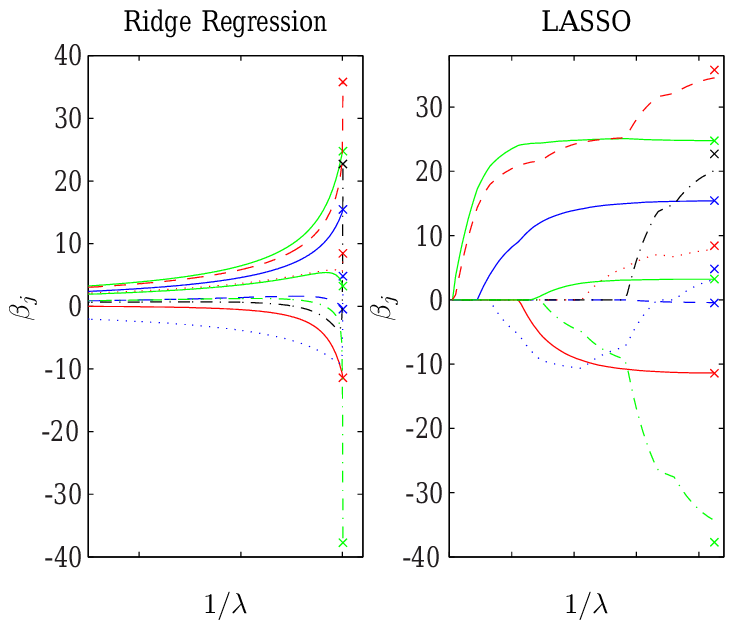

# Example of Lasso in scikit-learn

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso

In [5]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

sales = pd.read_csv('kc_house_data.csv', dtype=dtype_dict)

In [6]:
sales.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340.0,5650.0
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690.0,7639.0


We transform some of the features. We bring the square-footage closer together and pull the bedrooms and number of floors apart. For example, 2 and 4 are close together as integers, but those values carry much different importance in a house when it comes to number of bedrooms.

In [7]:
from math import log, sqrt

sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt']  = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']
sales['floors_square'] = sales['floors']*sales['floors']

We perform Lasso learning using sklearn:

In [8]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

model_all = Lasso(alpha=5e2, normalize=True) # set parameters
model_all.fit(sales[all_features], sales['price']) # learn weights

Lasso(alpha=500.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

To get the coefficients we use `.coef_` .

In [11]:
model_all.coef_

array([     0.        ,      0.        ,      0.        ,    134.43931396,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,  24750.00458561,      0.        ,
        61749.10309071,      0.        ,      0.        ,     -0.        ,
            0.        ])

Which features remain non-zero:

In [9]:
features_nonzero_weight = [all_features[i] for i in np.where(model_all.coef_ > 0.)[0].tolist()]
print(features_nonzero_weight)

['sqft_living', 'view', 'grade']


### To find a good l1 penalty.

Let's split into training, validation, and testing sets.

In [10]:
testing = pd.read_csv('wk3_kc_house_test_data.csv', dtype=dtype_dict)
training = pd.read_csv('wk3_kc_house_train_data.csv', dtype=dtype_dict)
validation = pd.read_csv('wk3_kc_house_valid_data.csv', dtype=dtype_dict)

Creating same features as above

In [11]:
testing['sqft_living_sqrt'] = testing['sqft_living'].apply(sqrt)
testing['sqft_lot_sqrt'] = testing['sqft_lot'].apply(sqrt)
testing['bedrooms_square'] = testing['bedrooms']*testing['bedrooms']
testing['floors_square'] = testing['floors']*testing['floors']

training['sqft_living_sqrt'] = training['sqft_living'].apply(sqrt)
training['sqft_lot_sqrt'] = training['sqft_lot'].apply(sqrt)
training['bedrooms_square'] = training['bedrooms']*training['bedrooms']
training['floors_square'] = training['floors']*training['floors']

validation['sqft_living_sqrt'] = validation['sqft_living'].apply(sqrt)
validation['sqft_lot_sqrt'] = validation['sqft_lot'].apply(sqrt)
validation['bedrooms_square'] = validation['bedrooms']*validation['bedrooms']
validation['floors_square'] = validation['floors']*validation['floors']

In [12]:
errors1 = []
for l1_penalty in np.logspace(1, 7, num=13):
    model = Lasso(alpha=l1_penalty, normalize=True)
    model.fit(training[all_features], training['price'])
    y_pred_step = model.predict(validation[all_features])
    errors1.append(((validation['price']- y_pred_step)**2).sum())

print('The best value for l1 penalty coefficient: ')
np.logspace(1,7,num=13).tolist()[errors1.index(min(errors1))]

The best value for l1 penalty coefficient: 


10.0

We plot the RSS values:

In [53]:
print(errors1)

[398213327300134.94, 399041900253346.94, 429791604072559.62, 463739831045121.06, 645898733633800.75, 1222506859427163.0, 1222506859427163.0, 1222506859427163.0, 1222506859427163.0, 1222506859427163.0, 1222506859427163.0, 1222506859427163.0, 1222506859427163.0]


In [45]:
np.logspace(1,7,num=13)

array([  1.00000000e+01,   3.16227766e+01,   1.00000000e+02,
         3.16227766e+02,   1.00000000e+03,   3.16227766e+03,
         1.00000000e+04,   3.16227766e+04,   1.00000000e+05,
         3.16227766e+05,   1.00000000e+06,   3.16227766e+06,
         1.00000000e+07])

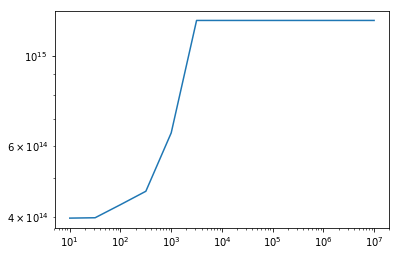

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(np.logspace(1,7,num=13),errors1)
plt.xscale('log')
plt.yscale('log')
plt.show()

Now we use the optimal alpha to train the model with it, and get RSS error on the test data.

In [14]:
model_alpha10 = Lasso(alpha=10,normalize=True).fit(training[all_features],training['price'])

In [15]:
alpha10_test_RSS = ((model_alpha10.predict(testing[all_features]) - testing['price'])**2).sum()
print(alpha10_test_RSS)

98467402552698.8


In [58]:
model_alpha10.coef_

array([ -1.61445628e+04,   3.73245384e+02,   5.08412433e+04,
         6.17853560e+02,  -4.44113549e+04,   7.85623065e-01,
        -7.01194765e+02,  -0.00000000e+00,   5.01420046e+03,
         6.19488752e+05,   3.80418557e+04,   2.49987718e+04,
         1.28716235e+05,   0.00000000e+00,   0.00000000e+00,
        -3.29383118e+03,   1.00573209e+01])

Number of nonzero coefficients

In [63]:
np.count_nonzero(model_alpha10.coef_) + np.count_nonzero(model_alpha10.intercept_)

15

In [62]:
len(model_alpha10.coef_)

17

What if we absolutely wanted to limit ourselves to, say, 7 features?

In [16]:
max_nonzeros = 7

In [17]:
nonZeroNumFeatures = []
for penalty in np.logspace(1, 4, num=20):
    model = Lasso(alpha=penalty,normalize=True).fit(training[all_features],training['price'])
    nonZeroNumFeatures.append(np.count_nonzero(model.coef_) + np.count_nonzero(model.intercept_))

In [18]:
print(nonZeroNumFeatures)

[15, 15, 15, 15, 13, 12, 11, 10, 7, 6, 6, 6, 5, 3, 3, 2, 1, 1, 1, 1]


In [19]:
nonZeroNumFeatures.index(15)

0

In [20]:
nonZeroNumFeaturesArray = np.array(nonZeroNumFeatures)
nonZeroNumFeaturesArray

array([15, 15, 15, 15, 13, 12, 11, 10,  7,  6,  6,  6,  5,  3,  3,  2,  1,
        1,  1,  1])

In [21]:
l1_penalty_min_pos = np.where(nonZeroNumFeaturesArray > 7)[0].tolist()[-1] # position largest penalty giving more than 7 non-zero features
l1_penalty_min = np.logspace(1, 4, num=20)[l1_penalty_min_pos]
l1_penalty_max_pos = np.where(nonZeroNumFeaturesArray<7)[0].tolist()[0] #position of smallest penalty giving less than 7 non-zero features
l1_penalty_max = np.logspace(1, 4, num=20)[l1_penalty_max_pos]

The coarse search gives upper and lower search limits on alpha to be:

In [135]:
print(l1_penalty_min)
print(l1_penalty_max)

127.42749857
263.665089873


In [110]:
rss_small_range=[]
nonZeroNumFeatures_2 = []
for l1_penalty in np.linspace(l1_penalty_min,l1_penalty_max, 20):
    model_narrow = Lasso(alpha=l1_penalty,normalize=True).fit(training[all_features],training['price'])
    y_pred = model_narrow.predict(validation[all_features])
    rss_small_range.append(((y_pred - validation['price'])**2).sum())
    nonZeroNumFeatures_2.append(np.count_nonzero(model_narrow.coef_) + np.count_nonzero(model_narrow.intercept_))

print(np.linspace(l1_penalty_min,l1_penalty_max, 20)[rss_small_range.index(min(rss_small_range))])
print(nonZeroNumFeatures_2)

127.42749857
[10, 10, 8, 8, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6]


In [128]:
index_7_nonzero = np.where(np.array(nonZeroNumFeatures_2) == 7)[0].tolist()

In [132]:
smallestRSS_7nonzero = np.array(rss_small_range)[index_7_nonzero].min()

In [139]:
np.linspace(l1_penalty_min,l1_penalty_max, 20)[rss_small_range.index(smallestRSS_7nonzero)]

156.10909673930755

In [140]:
np.linspace(l1_penalty_min,l1_penalty_max, 20)

array([ 127.42749857,  134.59789811,  141.76829765,  148.9386972 ,
        156.10909674,  163.27949628,  170.44989582,  177.62029537,
        184.79069491,  191.96109445,  199.13149399,  206.30189354,
        213.47229308,  220.64269262,  227.81309216,  234.9834917 ,
        242.15389125,  249.32429079,  256.49469033,  263.66508987])

We list the features which are non-zero when using the l1 penalty we found:

In [147]:
optimal_l1_penalty = np.linspace(l1_penalty_min,l1_penalty_max, 20)[rss_small_range.index(smallestRSS_7nonzero)]
model_optimal = Lasso(alpha=optimal_l1_penalty,normalize=True).fit(training[all_features],training['price'])
[all_features[i] for i in np.where(model_optimal.coef_ > 0)[0]]


['bathrooms', 'sqft_living', 'waterfront', 'view', 'grade']